In [54]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import pandas as pd
from flaml import AutoML

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(
    sorted_dyads_df,
    stress_lookback_days=0,
    sleep_days_to_keep=[1, 2],
)

feature_sets = {
    "index": True,
    "response": True,
    #
    "hr": True,
    "activity": True,
    "sleep": True,
    "stress": True,
    "overnight_hrv": True,
    "medical": True,
    "therapy": True,
    "child_demo": True,
    "parent_demo": True,
    "temporal": False,
}

df = pd.concat(
    [cleaned_dyads_dfs[key] for key, include in feature_sets.items() if include], axis=1
)
df_sham = df[df["Arm_Sham"]]
df_treat = df[~df["Arm_Sham"]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_2320/1342709441.py:12: DtypeWarning: Columns (95,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:135: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [55]:
df_train = df_sham
df_test = df_treat

In [43]:
automl = AutoML()

automl_settings = {
    "time_budget": 15,  # seconds
    # "train_time_limit": 1,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost"],
    # "split_type": time_series_split,
    "early_stop": True,
}


X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
print("Best config:", automl.best_config)

[flaml.automl.logger: 01-16 15:36:19] {1752} INFO - task = classification
[flaml.automl.logger: 01-16 15:36:19] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-16 15:36:19] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 01-16 15:36:19] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 01-16 15:36:19] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-16 15:36:19] {2417} INFO - Estimated sufficient time budget=3676s. Estimated necessary time budget=4s.
[flaml.automl.logger: 01-16 15:36:19] {2466} INFO -  at 1.1s,	estimator xgboost's best error=0.0262,	best estimator xgboost's best error=0.0262
[flaml.automl.logger: 01-16 15:36:19] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 01-16 15:36:19] {2466} INFO -  at 1.1s,	estimator xgboost's best error=0.0262,	best estimator xgboost's best error=0.0262
[flaml.automl.logger: 01-16 15:36:19] {2282} INFO - iteration 2, cur

In [56]:
import shap
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Fit the model if not already fitted

window = "30m"
X_train, y_train = prep_X_y(df_train, f"tantrum_within_{window}")
X_test, y_test = prep_X_y(df_test, response_column=f"tantrum_within_{window}")
model = XGBClassifier(**automl.best_config)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.6865


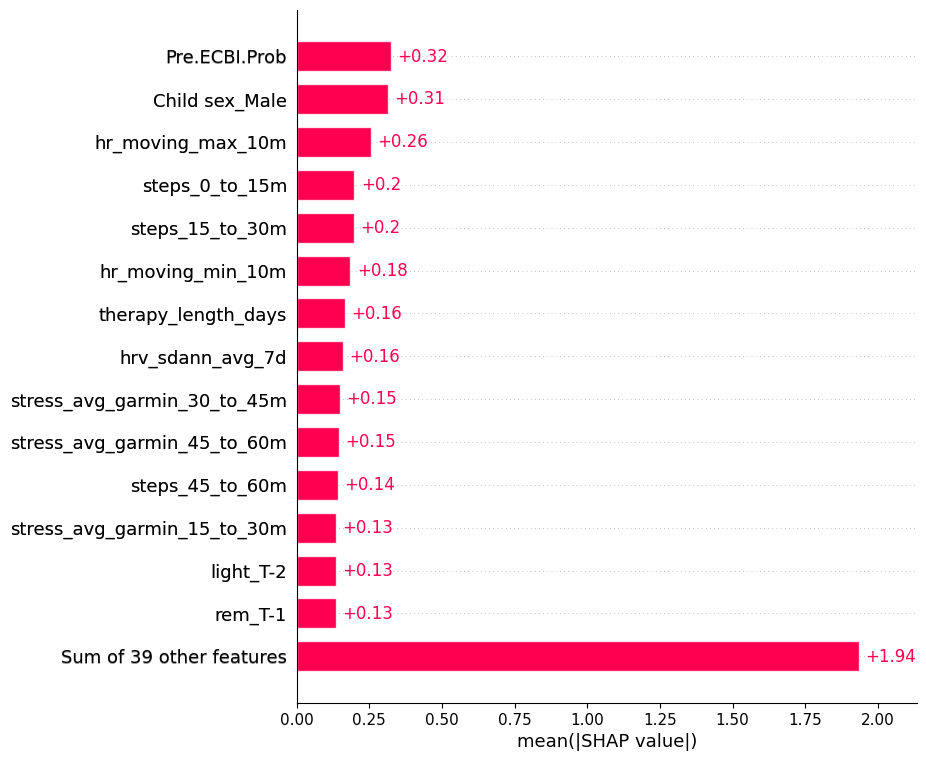

In [57]:
# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
# Note: Bar plot does not accept "group_remaining_features" argument
shap.plots.bar(shap_values, max_display=15)

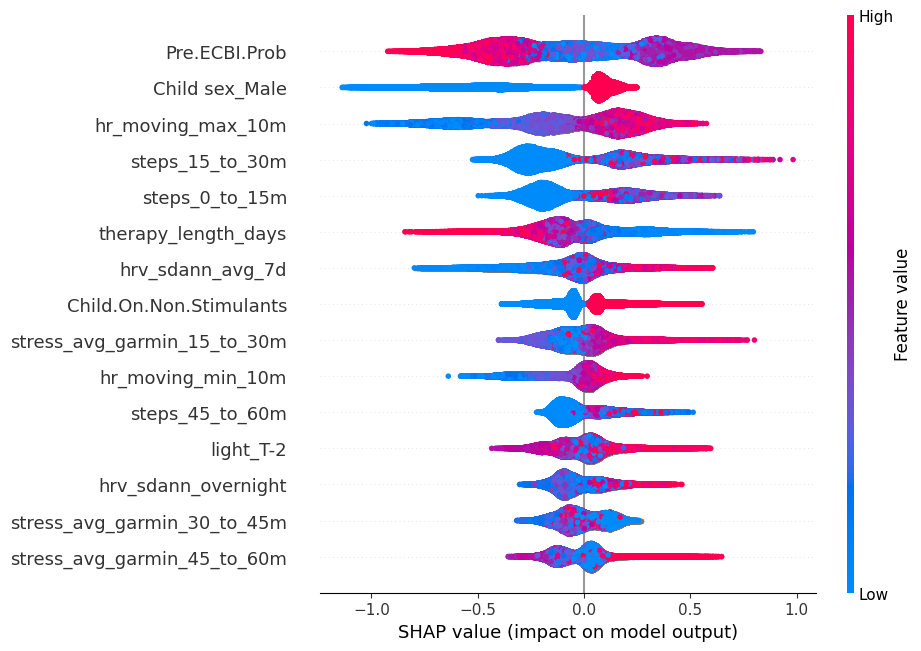

In [19]:
shap.plots.beeswarm(shap_values, max_display=15, group_remaining_features=False)

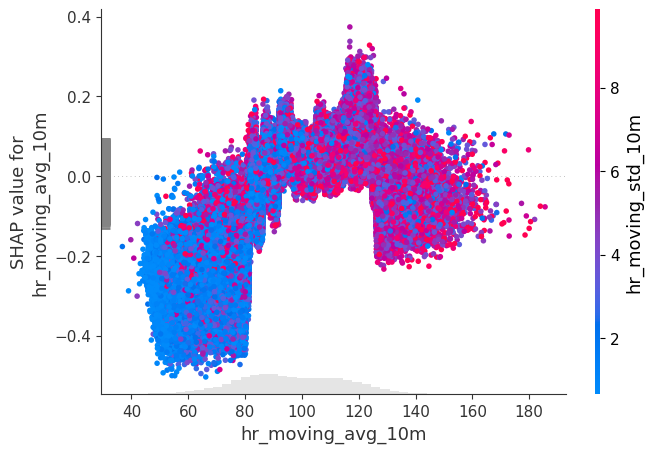

In [22]:
shap.plots.scatter(shap_values[:, "hr_moving_avg_10m"], color=shap_values)